In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

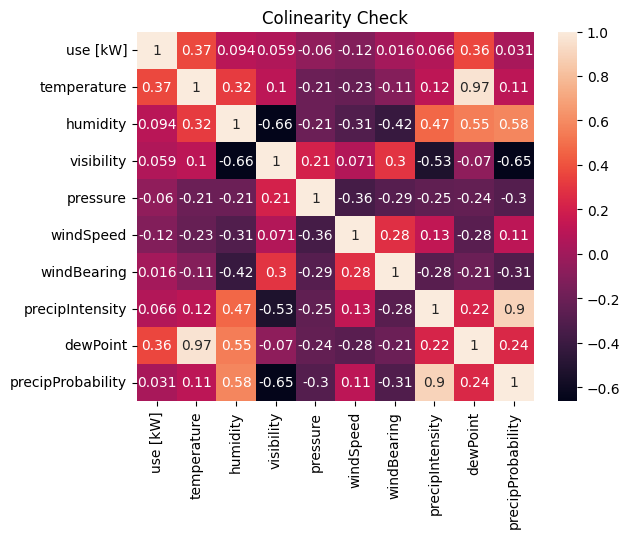

MODEL:

ROOT MEAN SQUARED ERROR:
7.285969580266151


In [ ]:
init_weather_df = pd.read_csv("weather_data.csv")
init_energy_df = pd.read_csv("energy_data (1).csv")
# print(init_energy_df.isnull().sum()) #checks if there are missing values in both the datasets
# print(init_weather_df.isnull().sum())

pd.set_option('display.max_rows', 100)

# cloudCover is missing many values which may produce bad models. There are so many missing vales that rather than
# imputing them, I am just going to drop the column entirely, as it may produce worse models than if i used some imputation method
init_weather_df.drop("cloudCover", axis = 1, inplace = True)

init_weather_df['dayNum'] = init_weather_df.index // 24 #floor division to get the day of each entry. first 24 rows will be 0, next 24 will be 1 and so on
weather_df = init_weather_df.groupby('dayNum').mean(numeric_only=True)
weather_df.reset_index(drop=True, inplace=True)

init_energy_df['dayNum'] = init_energy_df.index // 48 #floor division to get the day of each entry. first 48 rows will be 0, next 48 will be 1 and so on
energy_df = init_energy_df.groupby('dayNum')["use [kW]"].sum(numeric_only=True)
energy_df.reset_index(drop=True, inplace=True)

df = pd.concat([energy_df, weather_df], axis = 1)
df.drop("time", axis = 1, inplace = True)

corr = df.corr() # check for highly correlated features
sns.heatmap(corr, annot=True)
plt.title("Colinearity Check")
plt.show()

df.drop("dewPoint", axis = 1, inplace = True) # highly correlated with temperature

train_data = df[:-31]
test_data = df[-31:]

trainX = train_data.drop(['use [kW]'], axis=1)
trainY = train_data['use [kW]']
testX = test_data.drop(['use [kW]'], axis=1)
testY = test_data['use [kW]']

model1 = LinearRegression()
model1.fit(trainX, trainY)

model1_pred = model1.predict(testX)

print("MODEL:")

print("\nROOT MEAN SQUARED ERROR:")
print(np.sqrt(mean_squared_error(testY, model1_pred)))

output_df = pd.DataFrame(model1_pred)
start_date = '2023-12-01'
end_date = '2023-12-31'
dates_col = pd.date_range(start=start_date, end=end_date, freq='D')
output_df.insert(0, "Date", dates_col)

output_df.to_csv('cse351_hw2_buthorn_robert_112628833_linear_regression.csv', index=False) # outputs predictions and dates into the csv file

#This model works decently well, with a RMSE of 7.28, which represents on average how many kW away from the actual the predictions were.
#I believe that this model does not perfrom well with a linear regression because despite getting decent predictions, it appears that the data is not linear.
#For instance, when temperature gets higher in the summer, energy usage will increase with AC usage, but when temperature gets lower in the winter,
#energy usage actually still may increase because of the heat usage. This fluctuation, along with many other factors, made this data more difficult to model with a linear regression



In [ ]:
#Logistic regression

weather_df['tempClass'] = df['temperature'].apply(lambda x: 1 if x >= 35 else 0) #add column tempClass where temperature above 35 is 1, otherwise it is 0

dec_weather_df = weather_df[-31:]
train_weather_df = weather_df[:-31]

trainX = train_weather_df.drop(['tempClass'], axis=1)
trainY = train_weather_df['tempClass']
testX = dec_weather_df.drop(['tempClass'], axis=1)
testY = dec_weather_df['tempClass']

logreg = LogisticRegression()
logreg.fit(trainX, trainY)

logreg_pred = logreg.predict(testX)

LR_output_df = pd.DataFrame(logreg_pred)
LR_output_df.insert(0, "Date", dates_col)

LR_output_df.to_csv('cse351_hw2_buthorn_robert_112628833_logistic_regression.csv', index=False)  #output predictions to this csv file

print("F1 SCORE: ")
print(f1_score(testY, logreg_pred))

#This model had an f score of .59, which is an ok score for all intents and purposes. It can predict the temperature class with relative accuracy and precision


F1 SCORE: 
0.5909090909090909


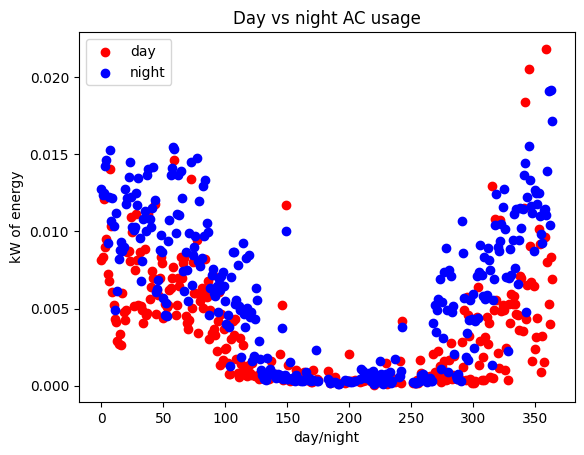

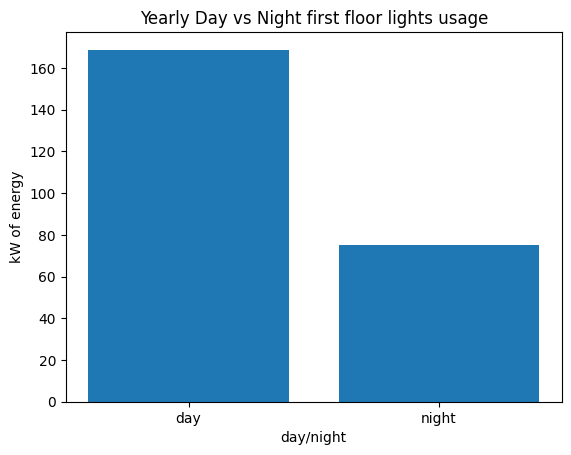

In [ ]:
# Comparing day/night usages

# create a new dataframe containing the day and night values so it is easier to plot the scatter plot later
AC_df = pd.DataFrame(columns = ["day", "night"])

day_group = init_energy_df.groupby('dayNum')

for day, df in day_group:
    day_sum = df.iloc[:6]['AC [kW]'].sum()
    night_sum = df.iloc[6:18]['AC [kW]'].sum()
    day_sum += df.iloc[18:24]['AC [kW]'].sum()

    if(day_sum > .1 or night_sum > .1):  # everything above this is an outlier, this method gives the graph shape instead of just a straight line around 0 with a few outliers
      continue

    AC_df.loc[day, 'day'] = day_sum
    AC_df.loc[day, 'night'] = night_sum

plt.scatter(AC_df.index, AC_df['day'], c='red', label='day')
plt.scatter(AC_df.index, AC_df['night'], c='blue', label='night')
plt.xlabel('day/night')
plt.ylabel('kW of energy')
plt.legend()
plt.title('Day vs night AC usage')

plt.show()

#This plot shows the relationship between both the day and night usage of AC and the yearly usage of AC. The yearly usage is parabolic, and dips during the summer months
#I checked the data and it seems that there were no preprocessing errors, so in terms of this scatterplot, this makes absolutely no sense. AC usage should get greater in the summer months,
#unless perhaps this data is from a different part of the world?

FFL_df = pd.DataFrame(columns = ["day", "night"])

day_group1 = init_energy_df.groupby('dayNum')
day_sum_FFL = 0
night_sum_FFL = 0

for day, df in day_group1:
    day_sum_FFL += df.iloc[:6]['AC [kW]'].sum()
    night_sum_FFL += df.iloc[6:18]['AC [kW]'].sum()
    day_sum_FFL += df.iloc[18:24]['AC [kW]'].sum()

labels = ['day', 'night']
values = [day_sum_FFL, night_sum_FFL]
bar_positions = range(len(labels))

plt.bar(bar_positions, values)

plt.xticks(bar_positions, labels)
plt.xlabel('day/night')
plt.ylabel('kW of energy')
plt.title('Yearly Day vs Night first floor lights usage')

plt.show()

#This plot is a simple bar graph showing the energy usage of the first floor lights during boht the day and the night over the course of a year
# It is clear that the lights get used more frequently during the day, almost double than at night in fact.